In [12]:
# GBM
from gbm.data import RSP, Cspec, TTE, GbmDetectorCollection, PHA  ### 数据类
from gbm.binning.unbinned import bin_by_time  # bin_by_snr,bin_by_edges
from gbm.plot import Lightcurve, Spectrum, ModelFit  ### 画图类
from gbm.background import BackgroundFitter  ### 背景拟合类
from gbm.background.binned import Polynomial
from gbm.spectra.fitting import SpectralFitterPgstat  ### 能谱拟合类
import gbm.spectra.functions as gbm_func

# Here
from Myfuncs.my_general_utils import *
import pandas as pd
from typing import Final
import gc
import matplotlib.pyplot as plt
plt.switch_backend("Agg")
plt.rcParams["agg.path.chunksize"] = 10000

In [23]:
MYRSP_MATRIX: Final[str] = "generated_rsp_files"
RAWDATA: Final[str] = "Raw_Data"
SAVEPATH: Final[str] = "GBMFIT_Generated_Final"
niteration = 100000
erange_nai = (10.0, 900.0)  # keV
erange_bgo = (300.0, 35000.0)


class FitResult:
    model_symbol: dict[str, list[str]] = {
        "Band": ["A", "Ep", "alpha", "Beta"],
        "Comptonized": ["A", "Ec", "alpha"],
        "Band+BlackBody": ["A", "Ep", "alpha", "Beta", "Ab", "kT"],
        "Comptonized+BlackBody": ["A", "Ec", "alpha", "Ab", "kT"],
    }

    def __init__(self, specfitter: SpectralFitterPgstat, model_name, cl: float = 0.683):
        self.model_name: str = model_name
        self.fit_success: bool = specfitter.success
        self.message: str = specfitter.message
        self.parameters: list[float] = specfitter.parameters
        self.asyerrors: list[list[float]] = specfitter.asymmetric_errors(cl)
        self.statistics: float = specfitter.statistic
        self.dof: float = specfitter.dof

    def __repr__(self):
        indent = " " * 4
        cls = self.__class__
        cls_name = cls.__name__
        res = [f"{self.model_name} {cls_name}("]
        res.append(f"{indent}fit success: {self.fit_success}")
        res.append(f"{indent}message: {self.message}")
        if self.model_name in cls.model_symbol.keys():
            for symbol, val, asyerr in zip(
                cls.model_symbol[self.model_name], self.parameters, self.asyerrors
            ):
                res.append(
                    f"{indent}{symbol.ljust(10)} {val:.4f} -{asyerr[0]:.4f} + {asyerr[1]:.4f}"
                )
        res.append(f"{indent}Pgstat: {self.statistics}")
        res.append(f"{indent}dof: {self.dof}")
        res.append(")")
        return "\n".join(res)


In [14]:
grb_names = [
    "bn100619015",
    "bn121031949",
    "bn140108721",
    "bn151027166",
    "bn170514180",
    "bn171120556",
    "bn180612785",
    "bn181222279",
    "bn190419414",
]

normal_bursts = pd.read_csv("chosen_GRB_informaions.csv")
normal_bursts = (
    normal_bursts[normal_bursts.name.isin(grb_names)]
    .reset_index()
    .drop(columns=["index"])
)
grb_files = get_GRB_files(RAWDATA, grb_names)

### bn140108721 没有rsp2文件，用rsp中的 RA DEC 来选择探头数据
bn140108_rawdata = os.listdir(joinpath(RAWDATA, "bn140108721"))
bn140108_rsps_name = sorted(list(filter(lambda x: ".rsp" in x, bn140108_rawdata)))
bn140108_rsps = [
    joinpath(RAWDATA, "bn140108721", rsp_name) for rsp_name in bn140108_rsps_name
]
bn140108_dets_angles = get_dets_angles(grb_files[2].trigdat_file, bn140108_rsps[0], 60)
grb_files[2].choose_by_dets(bn140108_dets_angles)


### bn181222279 没有n5探头的tte文件
grb_files[7].dets_selection = {"b0":-1, "n4":-1}

perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are compatible
the GRBfile bn140108721 does not have rsp2 files !!!
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the GRB files are incompatible
tte_files: 2	 cspec_files: 3	 rsp2_files: 3
perform the dets selection, filter the unchosen file
the GRB files are compatible
perform the dets selection, filter the unchosen file
the rsp2_files is missing


In [15]:
for grb_name, grb_file, grb_time, grb_bkg in zip(
    normal_bursts.name,
    grb_files,
    normal_bursts.grb_chosen_times,
    normal_bursts.background_interval,
):

    ### 对两个峰分别拟合
    for pulse_time in eval(grb_time):
        gc.collect()
        ### use new pulse_time to select generated rsp files
        ### change the grb_file.rsp2_files to generated rsp files
        grb_path = joinpath(MYRSP_MATRIX, grb_name)
        generated_rsp2 = os.listdir(grb_path)
        chosen_rsp2s = sorted(
            [pulse_rsp2 for pulse_rsp2 in generated_rsp2 if pulse_time in pulse_rsp2]
        )

        pulse_rsp2s = [joinpath(grb_path, pulse_rsp2) for pulse_rsp2 in chosen_rsp2s]
        grb_file.rsp2_files = pulse_rsp2s

        ### TTE ---> Binned Data
        rsp_list = [RSP.open(rsp) for rsp in grb_file.rsp2_files]
        tte_list = [TTE.open(tte) for tte in grb_file.tte_files]

        data_size = min(len(rsp_list), len(tte_list))
        ttes = GbmDetectorCollection.from_list(tte_list[:data_size])
        phaiis = GbmDetectorCollection.from_list(
            [tte.to_phaii(bin_by_time, 0.64, time_ref=0.0) for tte in ttes]
        )
        print(grb_name, ":", phaiis.detector())

        ### RSP
        rsps = GbmDetectorCollection.from_list(rsp_list[:data_size])

        ### 背景拟合
        bkgd_range = list(map(decode_3ml_timestr, grb_bkg.split(",")))
        print("Choose background: ", bkgd_range)
        backfitters = [
            BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_range)
            for phaii in phaiis
        ]
        backfitters = GbmDetectorCollection.from_list(backfitters, dets=ttes.detector())
        backfitters.fit(order=1)

        bkgds = backfitters.interpolate_bins(
            phaiis.data()[0].tstart, phaiis.data()[0].tstop
        )
        bkgds = GbmDetectorCollection.from_list(bkgds, dets=ttes.detector())

        ### 30keV ~ 40KeV 的channel mask
        chan_masks = [(i.emin < 30) | (i.emax > 40) for i in phaiis.data()]
        # chan_masks = [i.emin > -1 for i in phaiis.data()]

        ########### 返回之前的src_range
        src_range = decode_3ml_timestr(pulse_time)
        print("src_range: ", src_range)
        # 光变
        data_lcs = phaiis.to_lightcurve(
            nai_kwargs={"energy_range": erange_nai},
            bgo_kwargs={"energy_range": erange_bgo},
        )
        # the energy-integrated background
        bkgd_lcs = bkgds.integrate_energy(nai_args=erange_nai, bgo_args=erange_bgo)
        # 源时间选择
        src_lcs = phaiis.to_lightcurve(
            time_range=src_range,
            nai_kwargs={"energy_range": erange_nai},
            bgo_kwargs={"energy_range": erange_bgo},
        )

        # 计数谱
        data_specs = phaiis.to_spectrum(time_range=src_range)
        # the time-integrated background
        bkgd_specs = bkgds.integrate_time(*src_range)
        # 能量选择
        src_specs = phaiis.to_spectrum(
            time_range=src_range,
            nai_kwargs={"energy_range": erange_nai},
            bgo_kwargs={"energy_range": erange_bgo},
        )

        ### 检查图像
        mkdir(f"{SAVEPATH}/{grb_name}")
        lcplots = [
            Lightcurve(data=data_lc, background=bkgd_lc)
            for data_lc, bkgd_lc in zip(data_lcs, bkgd_lcs)
        ]
        for det, src_lc, lcplot in zip(bkgds._dets, src_lcs, lcplots):
            lcplot.add_selection(src_lc)
            lcplot.fig.savefig(f"{SAVEPATH}/{grb_name}/{det}_{src_range}_lc.png")

        specplots = [
            Spectrum(data=data_spec, background=bkgd_spec)
            for data_spec, bkgd_spec in zip(data_specs, bkgd_specs)
        ]
        for det, src_spec, specplot in zip(bkgds._dets, src_specs, specplots):
            specplot.add_selection(src_spec)
            specplot.fig.savefig(f"{SAVEPATH}/{grb_name}/{det}_{src_range}_spec.png")

        ### 能谱拟合
        phas = phaiis.to_pha(
            time_ranges=src_range,
            nai_kwargs={"energy_range": erange_nai},
            bgo_kwargs={"energy_range": erange_bgo},
        )

        # interpolate response files to get DRMs at center of the source window
        # rsps_interp = [rsp.interpolate(pha.tcent) for rsp, pha in zip(rsps, phas)]

        # print([chan_mask for chan_mask in chan_masks])
        steds = [(pha.valid_channels[0], pha.valid_channels[-1]) for pha in phas]
        for chan_mask, sted in zip(chan_masks, steds):
            chan_mask[: sted[0]] = False
            chan_mask[sted[1] + 1 :] = False
    break

bn100619015 : ['b0', 'n2', 'n5']
Choose background:  [[-25, -5], [30, 50], [160, 180]]
src_range:  [0, 12]
---  new folder  ---
bn100619015 : ['b0', 'n2', 'n5']
Choose background:  [[-25, -5], [30, 50], [160, 180]]
src_range:  [77, 101]
---  There is a folder with the same name!  ---


In [24]:
niteration = 100000
model = gbm_func.Band()
specfitter = SpectralFitterPgstat(
    phas,
    bkgds.to_list(),
    rsps.to_list(),
    method="SLSQP",
    channel_masks=chan_masks,
)
specfitter.fit(model, options={"maxfun": niteration})
FitResult(specfitter,model.name)

/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Band FitResult(
    fit success: True
    message: Optimization terminated successfully
    A          0.0075 -0.0005 + 0.0005
    Ep         92.4562 -11.7945 + 13.6745
    alpha      -1.3718 -0.0410 + 0.0434
    Beta       -9.2112 -0.7888 + 6.7477
    Pgstat: 264.793184875136
    dof: 346
)

In [17]:
from gbm.plot.gbmplot import ModelData,Histo
import numpy as np
modelplot_1 = ModelFit(fitter=specfitter)
model_counts = modelplot_1._fitter.model_count_spectrum()
energy, chanwidths, data_counts, data_counts_err, ulmasks = \
                                        modelplot_1._fitter.data_count_spectrum()
modelplot_1._count_models._name_dict.pop('all')
modelplot_1._count_data._name_dict.pop('all')
for i in range(modelplot_1._fitter.num_sets):
    det = ttes._dets[i]
    modelplot_1._count_models.insert(det, Histo(model_counts[i], modelplot_1._ax, 
                                edges_to_zero=False,  color=modelplot_1.colors[i], 
                                alpha=1.0, label=det))
    modelplot_1._count_data.insert(det, ModelData(energy[i], data_counts[i], 
                                            chanwidths[i], data_counts_err[i],
                                            modelplot_1._ax, ulmask=ulmasks[i], 
                                            color=modelplot_1.colors[i], 
                                            alpha=0.7, linewidth=0.9))

modelplot_1._ax.set_ylabel(r'Rate [count s$^{-1}$ keV$^{-1}$]')
modelplot_1._ax.set_ylim(1e-7, 100)
modelplot_1._set_view()
modelplot_1._ax.legend()

# if we don't already have residuals axis
if len(modelplot_1._figure.axes) == 1:
    modelplot_1._figure.add_axes(modelplot_1._resid_ax)

# get the residuals
energy, chanwidths, resid, resid_err = modelplot_1._fitter.residuals(sigma=True)

# plot for each detector/dataset
ymin, ymax = ([], [])
for i in range(modelplot_1._fitter.num_sets):
    det = ttes._dets[i]
    modelplot_1._resids.insert(det, ModelData(energy[i], resid[i], chanwidths[i],
                        resid_err[i], modelplot_1._resid_ax, color=modelplot_1.colors[i],
                        alpha=0.7, linewidth=0.9))
    ymin.append((resid[i]-resid_err[i]).min())
    ymax.append((resid[i]+resid_err[i]).max())
# the zero line
modelplot_1._resid_ax.axhline(0.0, color='black')
modelplot_1._resid_ax.set_xlabel('Energy [kev]', fontsize=10)
modelplot_1._resid_ax.set_ylabel('Residuals [sigma]', fontsize=10)


# we have to set the y-axis range manually, because the y-axis
# autoscale is broken (known issue) in matplotlib for this situation
ymin = np.min(ymin)
ymax = np.max(ymax)
modelplot_1._resid_ax.set_ylim((1.0-np.sign(ymin)*0.1)*ymin, 
                        (1.0+np.sign(ymax)*0.1)*ymax)

(-3.8425717415918115, 3.6688152520231703)

In [18]:
with open(f"GBM_fit_newrsp.txt", "a") as f:
    f.write(str(FitResult(specfitter,model.name)))
    f.write('\n\n')

/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/fitting.py:370: UserWarning: Parameter exists at its lower bound
  warnings.warn("Parameter exists at its lower bound")


/home/tsubakura/miniconda3/envs/fermiGBM/lib/python3.9/site-packages/gbm/spectra/fitting.py:600: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = multivariate_normal(self.parameters, self.covariance,


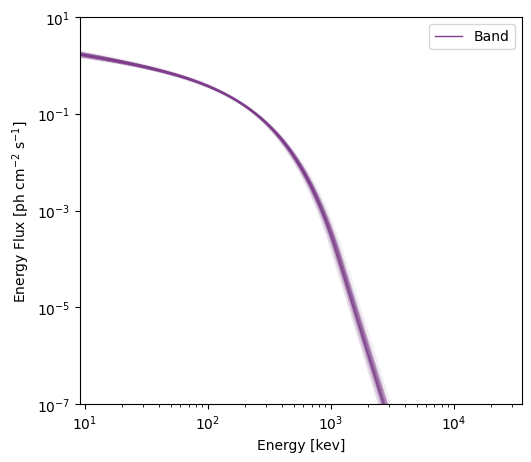

In [19]:
%matplotlib inline
modelplot_1.energy_spectrum(num_samples=200)
modelplot_1.ax.set_ylim(1e-7, 10)
modelplot_1.fig

In [20]:



# Example usage
file_path = "[77, 101]_fit.txt"
output_path = "fit_results.csv"
data = parse_fit_results(file_path)
df = pd.DataFrame(data)
df.to_csv(output_path, index=False)

print(f"CSV file '{output_path}' has been created.")


CSV file 'fit_results.csv' has been created.


In [25]:
data

[{'Model': 'Band',
  'Fit Success': 'True',
  'Optimization': 'terminated successfully',
  'A': '0.0075 -0.0005 + 0.0005',
  'Ep': '92.4562 -11.7945 + 13.6745',
  'alpha': '-1.3718 -0.0410 + 0.0434',
  'Beta': '-9.2112 -0.7888 + 6.7477',
  'Pgstat:': '264.793184875136',
  'dof:': '346'},
 {'Model': 'Band+BlackBody',
  'Fit Success': 'False',
  'Inequality': 'constraints incompatible',
  'A': '0.0100 -0.0100 + 0.0000',
  'Ep': '500.0000 -499.9900 + 0.3170',
  'alpha': '-0.5000 -0.0020 + 0.8344',
  'Beta': '-2.5000 -7.5000 + 0.0198',
  'Ab': '0.0100 -0.0000 + 0.0000',
  'kT': '30.0000 -30.0000 + 0.0000',
  'Pgstat:': '2536328.524576742',
  'dof:': '344'},
 {'Model': 'Comptonized',
  'Fit Success': 'True',
  'Optimization': 'terminated successfully',
  'A': '0.0075 -0.0004 + 0.0004',
  'Ec': '92.6250 -10.3330 + 11.7525',
  'alpha': '-1.3728 -0.0358 + 0.0372',
  'Pgstat:': '264.7930251889712',
  'dof:': '347'},
 {'Model': 'Comptonized+BlackBody',
  'Fit Success': 'False',
  'Inequality': '